### Model 1

In [1]:
import pandas as pd

dataset = pd.read_csv("../training_data.csv",index_col = ['id'], usecols = ['id','tweet','subtask_a'])
dataset.columns = ['tweet', 'sentiment']
dataset.dropna(inplace = True)
dataset.reset_index(drop = True, inplace = True)
print(dataset.head(n = 5))
print(len(dataset.columns))
print(dataset.size)

                                               tweet sentiment
0  @USER She should ask a few native Americans wh...       OFF
1  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF
2  Amazon is investigating Chinese employees who ...       NOT
3  @USER Someone should'veTaken" this piece of sh...       OFF
4  @USER @USER Obama wanted liberals &amp; illega...       NOT
2
26480


In [2]:
print(len(dataset.sentiment) == len(dataset.tweet))
print(dataset.sentiment.unique())

# Very Very disturbing error in the dataset. Thank god, I found it.
dataset = dataset.drop(dataset[(dataset.sentiment != 'OFF') & (dataset.sentiment != 'NOT')].index)

print(dataset.sentiment.unique())
print(dataset.sentiment.value_counts())

True
['OFF' 'NOT' ' for all the PMs handouts already have legal status in US'
 '”\xa0and has' ' tries gun control. “In other places'
 ' even while I profit causing it!) #liberals ' " R's and D's"
 ' small voice. It does not shout at you' '... URL']
['OFF' 'NOT']
NOT    8835
OFF    4398
Name: sentiment, dtype: int64


In [3]:
import preprocess as pp

In [4]:
clean_tweet = pp.clean_HTML(dataset.tweet)
clean_tweet = pp.clean_emoticons(clean_tweet)
clean_tweet = pp.clean_emojis(clean_tweet)
clean_tweet = pp.clean_tokens(clean_tweet)
clean_tweet = pp.clean_mentions(clean_tweet)
clean_tweet = pp.clean_hashtags(clean_tweet)
clean_tweet = pp.expand_contractions(clean_tweet)
clean_tweet = pp.lemmatize(clean_tweet)
clean_tweet = pp.remove_stop_words(clean_tweet)
clean_tweet = pp.clean_censored_words(clean_tweet)
clean_tweet = pp.remove_punctuators(clean_tweet)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [5]:
dataset['clean_tweet'] = clean_tweet

In [6]:
import numpy as np

def encode_labels(labels):
    encoded_labels = []
    for label in labels:
        if label == 'OFF':
            encoded_labels.append(1)
        else:
            encoded_labels.append(0)   
    return np.asarray(encoded_labels)

In [7]:
dataset['label'] = encode_labels(dataset.sentiment)

In [8]:
X_train = dataset.clean_tweet
y_train = dataset.label

print(len(X_train[y_train == 0]), len(X_train[y_train == 1]))

8835 4398


In [9]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

c:\users\dyanesh\anaconda3\envs\deep_learning\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [11]:
all_x = X_train
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [12]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|███████████████████████████████████████████████████████████████████████| 13233/13233 [00:00<00:00, 1850847.83it/s]


In [13]:
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 13233/13233 [00:00<00:00, 1154369.19it/s]


In [14]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|███████████████████████████████████████████████████████████████████████| 13233/13233 [00:00<00:00, 1208351.83it/s]


In [15]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha


100%|███████████████████████████████████████████████████████████████████████| 13233/13233 [00:00<00:00, 2203383.28it/s]


Wall time: 9.09 s


In [16]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [17]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [18]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 7938 word vectors.


In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

Using TensorFlow backend.


In [20]:
max_len = max([len(x.split()) for x in X_train])
x_train_seq = pad_sequences(sequences, maxlen=max_len)

In [31]:
num_words = 20000
embedding_dim = 200
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

In [35]:
tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)

output = Activation('sigmoid')(merged)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 57, 200)      4000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 56, 100)      40100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 55, 100)      60100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [36]:
from keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

Train on 10586 samples, validate on 2647 samples
Epoch 1/10
10586/10586 [==============================] - ETA: 34:00 - loss: 0.7167 - acc: 0.71 - ETA: 11:23 - loss: 0.6391 - acc: 0.66 - ETA: 6:51 - loss: 0.6972 - acc: 0.6687 - ETA: 4:55 - loss: 0.7154 - acc: 0.629 - ETA: 3:50 - loss: 0.7074 - acc: 0.638 - ETA: 3:09 - loss: 0.7014 - acc: 0.642 - ETA: 2:40 - loss: 0.7042 - acc: 0.639 - ETA: 2:19 - loss: 0.6962 - acc: 0.645 - ETA: 2:03 - loss: 0.6925 - acc: 0.647 - ETA: 1:51 - loss: 0.6855 - acc: 0.648 - ETA: 1:40 - loss: 0.6832 - acc: 0.638 - ETA: 1:32 - loss: 0.6840 - acc: 0.631 - ETA: 1:25 - loss: 0.6902 - acc: 0.627 - ETA: 1:19 - loss: 0.6855 - acc: 0.633 - ETA: 1:13 - loss: 0.6767 - acc: 0.642 - ETA: 1:09 - loss: 0.6767 - acc: 0.643 - ETA: 1:05 - loss: 0.6720 - acc: 0.645 - ETA: 1:01 - loss: 0.6695 - acc: 0.646 - ETA: 58s - loss: 0.6722 - acc: 0.643 - ETA: 55s - loss: 0.6728 - acc: 0.64 - ETA: 53s - loss: 0.6779 - acc: 0.64 - ETA: 50s - loss: 0.6742 - acc: 0.64 - ETA: 48s - loss: 0.

10586/10586 [==============================] - ETA: 9s - loss: 0.2539 - acc: 0.875 - ETA: 8s - loss: 0.2473 - acc: 0.927 - ETA: 10s - loss: 0.2415 - acc: 0.91 - ETA: 10s - loss: 0.2810 - acc: 0.89 - ETA: 9s - loss: 0.2890 - acc: 0.8906 - ETA: 10s - loss: 0.2873 - acc: 0.89 - ETA: 10s - loss: 0.2781 - acc: 0.89 - ETA: 9s - loss: 0.2707 - acc: 0.8971 - ETA: 9s - loss: 0.2658 - acc: 0.901 - ETA: 9s - loss: 0.2681 - acc: 0.900 - ETA: 9s - loss: 0.2634 - acc: 0.901 - ETA: 9s - loss: 0.2700 - acc: 0.896 - ETA: 9s - loss: 0.2665 - acc: 0.898 - ETA: 9s - loss: 0.2630 - acc: 0.899 - ETA: 9s - loss: 0.2621 - acc: 0.900 - ETA: 9s - loss: 0.2575 - acc: 0.901 - ETA: 9s - loss: 0.2561 - acc: 0.903 - ETA: 9s - loss: 0.2549 - acc: 0.905 - ETA: 9s - loss: 0.2554 - acc: 0.903 - ETA: 8s - loss: 0.2559 - acc: 0.903 - ETA: 8s - loss: 0.2604 - acc: 0.901 - ETA: 8s - loss: 0.2634 - acc: 0.901 - ETA: 8s - loss: 0.2598 - acc: 0.903 - ETA: 8s - loss: 0.2565 - acc: 0.906 - ETA: 8s - loss: 0.2564 - acc: 0.906 - E

10586/10586 [==============================] - ETA: 4s - loss: 0.0320 - acc: 1.000 - ETA: 8s - loss: 0.0309 - acc: 1.000 - ETA: 9s - loss: 0.0452 - acc: 0.987 - ETA: 9s - loss: 0.0497 - acc: 0.986 - ETA: 9s - loss: 0.0499 - acc: 0.987 - ETA: 9s - loss: 0.0457 - acc: 0.989 - ETA: 9s - loss: 0.0422 - acc: 0.991 - ETA: 9s - loss: 0.0488 - acc: 0.986 - ETA: 9s - loss: 0.0460 - acc: 0.987 - ETA: 9s - loss: 0.0447 - acc: 0.989 - ETA: 9s - loss: 0.0447 - acc: 0.990 - ETA: 9s - loss: 0.0450 - acc: 0.989 - ETA: 9s - loss: 0.0447 - acc: 0.989 - ETA: 9s - loss: 0.0440 - acc: 0.988 - ETA: 9s - loss: 0.0448 - acc: 0.988 - ETA: 9s - loss: 0.0428 - acc: 0.989 - ETA: 9s - loss: 0.0452 - acc: 0.988 - ETA: 9s - loss: 0.0435 - acc: 0.988 - ETA: 8s - loss: 0.0452 - acc: 0.987 - ETA: 8s - loss: 0.0471 - acc: 0.986 - ETA: 8s - loss: 0.0465 - acc: 0.987 - ETA: 8s - loss: 0.0454 - acc: 0.987 - ETA: 8s - loss: 0.0447 - acc: 0.988 - ETA: 8s - loss: 0.0540 - acc: 0.987 - ETA: 8s - loss: 0.0583 - acc: 0.986 - ETA

10586/10586 [==============================] - ETA: 9s - loss: 0.0178 - acc: 1.000 - ETA: 10s - loss: 0.0130 - acc: 1.00 - ETA: 10s - loss: 0.0137 - acc: 1.00 - ETA: 10s - loss: 0.0126 - acc: 1.00 - ETA: 10s - loss: 0.0110 - acc: 1.00 - ETA: 10s - loss: 0.0094 - acc: 1.00 - ETA: 9s - loss: 0.0095 - acc: 1.0000 - ETA: 10s - loss: 0.0095 - acc: 1.00 - ETA: 10s - loss: 0.0095 - acc: 1.00 - ETA: 9s - loss: 0.0092 - acc: 1.0000 - ETA: 9s - loss: 0.0183 - acc: 0.998 - ETA: 9s - loss: 0.0190 - acc: 0.997 - ETA: 9s - loss: 0.0278 - acc: 0.995 - ETA: 9s - loss: 0.0264 - acc: 0.995 - ETA: 9s - loss: 0.0249 - acc: 0.995 - ETA: 9s - loss: 0.0247 - acc: 0.995 - ETA: 9s - loss: 0.0235 - acc: 0.995 - ETA: 9s - loss: 0.0224 - acc: 0.995 - ETA: 9s - loss: 0.0215 - acc: 0.995 - ETA: 9s - loss: 0.0208 - acc: 0.996 - ETA: 9s - loss: 0.0199 - acc: 0.996 - ETA: 9s - loss: 0.0196 - acc: 0.996 - ETA: 8s - loss: 0.0222 - acc: 0.995 - ETA: 8s - loss: 0.0215 - acc: 0.996 - ETA: 8s - loss: 0.0209 - acc: 0.996 - E

10586/10586 [==============================] - ETA: 10s - loss: 0.0034 - acc: 1.00 - ETA: 10s - loss: 0.0048 - acc: 1.00 - ETA: 10s - loss: 0.0112 - acc: 1.00 - ETA: 11s - loss: 0.0162 - acc: 0.99 - ETA: 10s - loss: 0.0162 - acc: 0.99 - ETA: 10s - loss: 0.0139 - acc: 0.99 - ETA: 10s - loss: 0.0123 - acc: 0.99 - ETA: 10s - loss: 0.0115 - acc: 0.99 - ETA: 10s - loss: 0.0133 - acc: 0.99 - ETA: 10s - loss: 0.0122 - acc: 0.99 - ETA: 10s - loss: 0.0113 - acc: 0.99 - ETA: 10s - loss: 0.0109 - acc: 0.99 - ETA: 10s - loss: 0.0115 - acc: 0.99 - ETA: 10s - loss: 0.0112 - acc: 0.99 - ETA: 9s - loss: 0.0105 - acc: 0.9978 - ETA: 9s - loss: 0.0102 - acc: 0.998 - ETA: 9s - loss: 0.0109 - acc: 0.997 - ETA: 9s - loss: 0.0106 - acc: 0.997 - ETA: 9s - loss: 0.0102 - acc: 0.997 - ETA: 9s - loss: 0.0098 - acc: 0.997 - ETA: 9s - loss: 0.0094 - acc: 0.997 - ETA: 9s - loss: 0.0117 - acc: 0.997 - ETA: 9s - loss: 0.0121 - acc: 0.997 - ETA: 9s - loss: 0.0121 - acc: 0.997 - ETA: 9s - loss: 0.0117 - acc: 0.997 - ET

In [37]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.7609.hdf5')

In [21]:
test_dataset = pd.read_csv("../test_data.csv", usecols = ['id','tweet','subtask_a'])
test_dataset.columns = ['id','tweet', 'sentiment']
test_dataset.dropna(inplace = True)
test_dataset.reset_index(drop = True, inplace = True)


In [22]:
X_test = test_dataset.tweet
y_test = encode_labels(test_dataset.sentiment)
X_test = pp.clean_HTML(X_test)
X_test = pp.clean_emoticons(X_test)
X_test = pp.clean_emojis(X_test)
X_test = pp.clean_tokens(X_test)
X_test = pp.clean_mentions(X_test)
X_test = pp.clean_hashtags(X_test)
X_test = pp.expand_contractions(X_test)
X_test = pp.lemmatize(X_test)
X_test = pp.remove_stop_words(X_test)
X_test = pp.clean_censored_words(X_test)
X_test = pp.remove_punctuators(X_test)

sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(sequences_test, maxlen=max_len)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [142]:
loaded_CNN_model.evaluate(x=X_test_seq, y=y_test)

862/862 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 2ms/step


[0.4381235528158201, 0.8062645006069175]

In [143]:
yhat_cnn = loaded_CNN_model.predict(X_test_seq)
print(yhat_cnn[:10] > 0.5)
print((y_test[:10]),(yhat_cnn[:10]))

[[False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]]
[0 0 0 0 0 1 0 0 0 0] [[0.46275577]
 [0.15365078]
 [0.60607463]
 [0.06313677]
 [0.22742514]
 [0.94440687]
 [0.6807167 ]
 [0.18869807]
 [0.08093023]
 [0.10084254]]


In [25]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


[[561 118]
 [ 77 106]]
Confusion matrix, without normalization
[[561 118]
 [ 77 106]]


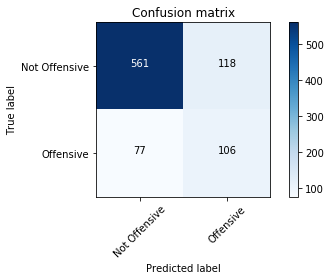

In [144]:


y_pred = (yhat_cnn > 0.4)
cn_matrix = confusion_matrix(y_test, y_pred)
print(cn_matrix)

plot_confusion_matrix(cn_matrix, ['Not Offensive', 'Offensive'])

In [145]:

print(f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

0.6864103697816681


### Model 2

In [123]:
import os

# I am trying Google's pre-trained word embeddings. Let's see how it performs. I hope it does well.
model_ggl_w2v = gensim.models.KeyedVectors.load_word2vec_format("../Datasets/GoogleNews-vectors-negative300.bin", binary=True)  


In [124]:
ggl_embedding_index= {}

for w in model_ggl_w2v.vocab.keys():
    ggl_embedding_index[w] = model_ggl_w2v[w]

print("There are {number} words with that many vectors..".format(number=len(ggl_embedding_index)))

There are 3000000 words with that many vectors..


In [125]:
ggl_num_words = 30000
ggl_embedding_dimension = 300
ggl_embedding_matrix = np.zeros((ggl_num_words, ggl_embedding_dimension))
for word, i in tokenizer.word_index.items():
    if i >= ggl_num_words:
        continue
    embedding_vector = ggl_embedding_index.get(word)
    if embedding_vector is not None:
        ggl_embedding_matrix[i] = embedding_vector

In [176]:
tweet_input = Input(shape=(max_len,), dtype='int32')
tweet_encoder = Embedding(ggl_num_words, ggl_embedding_dimension, weights=[ggl_embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()


'''
from keras.optimizers import Adam

tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(ggl_num_words, ggl_embedding_dimension, weights=[ggl_embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(2)(merged)
output = Activation('softmax')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-3),
                  metrics=['acc'])
model.summary()


'''


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 57, 300)      9000000     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 56, 100)      60100       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 55, 100)      90100       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_30 

"\nfrom keras.optimizers import Adam\n\ntweet_input = Input(shape=(max_len,), dtype='int32')\n\ntweet_encoder = Embedding(ggl_num_words, ggl_embedding_dimension, weights=[ggl_embedding_matrix], input_length=max_len, trainable=True)(tweet_input)\nbigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)\nbigram_branch = GlobalMaxPooling1D()(bigram_branch)\ntrigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)\ntrigram_branch = GlobalMaxPooling1D()(trigram_branch)\nfourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)\nfourgram_branch = GlobalMaxPooling1D()(fourgram_branch)\nmerged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)\n\nmerged = Dense(256, activation='relu')(merged)\nmerged = Dropout(0.2)(merged)\nmerged = Dense(2)(merged)\noutput = Activation('softmax')(merged)\nmodel = Model(in

In [ ]:
filepath="CNN_ggl_best_weights.{epoch:02d}-{val_acc:.4f}_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split = 0.2, callbacks = [checkpoint])

Train on 10586 samples, validate on 2647 samples
Epoch 1/10


In [28]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_ggl_best_weights.01-0.7888.hdf5')
loaded_CNN_model.evaluate(x=X_test_seq, y=y_test)
yhat_cnn = loaded_CNN_model.predict(X_test_seq)
y_pred = (yhat_cnn > 0.5)

862/862 [==============================] - ETA:  - ETA:  - ETA:  - 0s 367us/step


In [29]:
decode = lambda x: "OFF" if x == 1 else "NOT"
test_dataset['predictions'] = np.array([decode(y) for y in y_pred])

In [30]:
test_dataset['prob 0'] = yhat_cnn
test_dataset['prob 1'] = 1 - yhat_cnn

badwords = pd.read_csv("../badwords_list.csv")
badwordslist = badwords['Words']


for i in range(len(test_dataset)):
    if((test_dataset.loc[i,'prob 0']>=0.70) or test_dataset.loc[i,'prob 1']>=0.70):
        j=0
    else:
        line = test_dataset.loc[i,'tweet']
        if(line=="" or type(line)!=str):
            test_dataset.loc[i,"predictions"]='NOT'
            continue                       
        flag =False
        for word in badwordslist:
            if word in line.split():
                flag=True
                test_dataset.loc[i,"predictions"]='OFF'
                break
        if(flag==False):
            test_dataset.loc[i,"predictions"]='NOT'


In [31]:
y_pred = encode_labels(test_dataset['predictions'])

[[648  31]
 [ 87  96]]
Confusion matrix, without normalization
[[648  31]
 [ 87  96]]
0.767951818223297


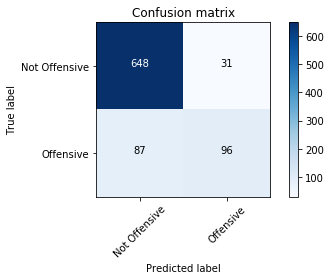

In [32]:
cn_matrix = confusion_matrix(y_test, y_pred)

print(cn_matrix)

plot_confusion_matrix(cn_matrix, ['Not Offensive', 'Offensive'])
print(f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

[[623  56]
 [ 80 103]]
Confusion matrix, without normalization
[[623  56]
 [ 80 103]]
0.7519655385448667


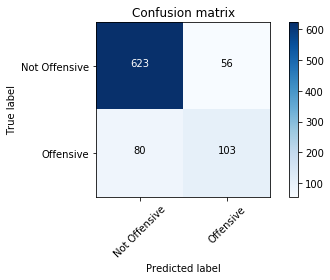

In [148]:
yhat_cnn = loaded_CNN_model.predict(X_test_seq)

y_pred = (yhat_cnn > 0.5)
test_dataset['label'] = y_pred
cn_matrix = confusion_matrix(y_test, y_pred)

print(cn_matrix)

plot_confusion_matrix(cn_matrix, ['Not Offensive', 'Offensive'])
print(f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

In [34]:
test_result = test_dataset.copy()
test_result.drop(columns = ['tweet','sentiment','prob 0', 'prob 1'], inplace = True)

    
# decode = lambda x: "OFF" if x == 1 else "NOT"
# test_result['label'] = np.array([decode(y) for y in y_pred])

# print(y_pred[:5])
print(test_result.head())
print(test_result.count())
test_result.to_csv("Subtask_A_CNN_GloVe.csv", header = False, index = False)

      id predictions
0  15923         NOT
1  27014         NOT
2  30530         NOT
3  13876         NOT
4  60133         NOT
id             862
predictions    862
dtype: int64


In [135]:
from keras.layers import LSTM, GRU, MaxPooling1D

tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(ggl_num_words, ggl_embedding_dimension, weights=[ggl_embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = MaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = MaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = MaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
lstm = LSTM(64)(merged)
lstm = Dropout(0.2)(lstm)
lstm = Dense(1)(lstm)
output = Activation('sigmoid')(lstm)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 57, 300)      9000000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 56, 100)      60100       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 55, 100)      90100       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_15 

In [136]:
# filepath="CNN_LSTM_ggl_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
filepath="CNN_LSTM_ggl_best_weights_2.{epoch:02d}-{val_acc:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split = 0.2, callbacks = [checkpoint])

Train on 10586 samples, validate on 2647 samples
Epoch 1/10


 6496/10586 [=================>............] - ETA: 25:10 - loss: 0.6950 - acc: 0.56 - ETA: 13:41 - loss: 0.7036 - acc: 0.53 - ETA: 9:46 - loss: 0.6913 - acc: 0.5625 - ETA: 7:51 - loss: 0.6929 - acc: 0.554 - ETA: 6:42 - loss: 0.6990 - acc: 0.537 - ETA: 5:57 - loss: 0.6963 - acc: 0.536 - ETA: 5:23 - loss: 0.6911 - acc: 0.558 - ETA: 4:57 - loss: 0.6872 - acc: 0.578 - ETA: 4:38 - loss: 0.6830 - acc: 0.593 - ETA: 4:23 - loss: 0.6825 - acc: 0.593 - ETA: 4:10 - loss: 0.6790 - acc: 0.605 - ETA: 3:58 - loss: 0.6735 - acc: 0.617 - ETA: 3:49 - loss: 0.6764 - acc: 0.610 - ETA: 3:42 - loss: 0.6687 - acc: 0.625 - ETA: 3:35 - loss: 0.6666 - acc: 0.631 - ETA: 3:30 - loss: 0.6662 - acc: 0.632 - ETA: 3:24 - loss: 0.6609 - acc: 0.637 - ETA: 3:19 - loss: 0.6571 - acc: 0.642 - ETA: 3:14 - loss: 0.6576 - acc: 0.643 - ETA: 3:11 - loss: 0.6607 - acc: 0.640 - ETA: 3:09 - loss: 0.6605 - acc: 0.639 - ETA: 3:05 - loss: 0.6609 - acc: 0.639 - ETA: 3:01 - loss: 0.6645 - acc: 0.633 - ETA: 2:58 - loss: 0.6632 - acc: 

 6560/10586 [=================>............] - ETA: 1:44 - loss: 0.4178 - acc: 0.781 - ETA: 1:54 - loss: 0.3728 - acc: 0.859 - ETA: 1:59 - loss: 0.3456 - acc: 0.895 - ETA: 2:06 - loss: 0.3693 - acc: 0.859 - ETA: 2:06 - loss: 0.3703 - acc: 0.850 - ETA: 2:07 - loss: 0.3605 - acc: 0.859 - ETA: 2:08 - loss: 0.3423 - acc: 0.866 - ETA: 2:08 - loss: 0.3630 - acc: 0.839 - ETA: 2:07 - loss: 0.3577 - acc: 0.840 - ETA: 2:07 - loss: 0.3571 - acc: 0.843 - ETA: 2:07 - loss: 0.3504 - acc: 0.849 - ETA: 2:06 - loss: 0.3515 - acc: 0.846 - ETA: 2:06 - loss: 0.3587 - acc: 0.843 - ETA: 2:05 - loss: 0.3507 - acc: 0.846 - ETA: 2:05 - loss: 0.3516 - acc: 0.845 - ETA: 2:05 - loss: 0.3483 - acc: 0.849 - ETA: 2:05 - loss: 0.3351 - acc: 0.856 - ETA: 2:04 - loss: 0.3400 - acc: 0.855 - ETA: 2:04 - loss: 0.3435 - acc: 0.855 - ETA: 2:04 - loss: 0.3424 - acc: 0.857 - ETA: 2:04 - loss: 0.3511 - acc: 0.852 - ETA: 2:05 - loss: 0.3493 - acc: 0.855 - ETA: 2:06 - loss: 0.3424 - acc: 0.858 - ETA: 2:06 - loss: 0.3382 - acc: 0

10586/10586 [==============================] - ETA: 50s - loss: 0.3461 - acc: 0.85 - ETA: 49s - loss: 0.3459 - acc: 0.85 - ETA: 49s - loss: 0.3462 - acc: 0.85 - ETA: 49s - loss: 0.3465 - acc: 0.85 - ETA: 48s - loss: 0.3473 - acc: 0.85 - ETA: 48s - loss: 0.3476 - acc: 0.85 - ETA: 47s - loss: 0.3486 - acc: 0.85 - ETA: 47s - loss: 0.3487 - acc: 0.85 - ETA: 47s - loss: 0.3483 - acc: 0.85 - ETA: 46s - loss: 0.3491 - acc: 0.85 - ETA: 46s - loss: 0.3490 - acc: 0.85 - ETA: 45s - loss: 0.3496 - acc: 0.85 - ETA: 45s - loss: 0.3494 - acc: 0.85 - ETA: 44s - loss: 0.3491 - acc: 0.85 - ETA: 44s - loss: 0.3489 - acc: 0.85 - ETA: 44s - loss: 0.3487 - acc: 0.85 - ETA: 43s - loss: 0.3485 - acc: 0.85 - ETA: 43s - loss: 0.3486 - acc: 0.85 - ETA: 42s - loss: 0.3481 - acc: 0.85 - ETA: 42s - loss: 0.3481 - acc: 0.85 - ETA: 42s - loss: 0.3482 - acc: 0.85 - ETA: 41s - loss: 0.3485 - acc: 0.85 - ETA: 41s - loss: 0.3483 - acc: 0.85 - ETA: 40s - loss: 0.3479 - acc: 0.85 - ETA: 40s - loss: 0.3489 - acc: 0.85 - ETA

 6560/10586 [=================>............] - ETA: 2:06 - loss: 0.2377 - acc: 0.937 - ETA: 2:08 - loss: 0.1960 - acc: 0.968 - ETA: 2:09 - loss: 0.2007 - acc: 0.968 - ETA: 2:07 - loss: 0.2203 - acc: 0.953 - ETA: 2:09 - loss: 0.2131 - acc: 0.937 - ETA: 2:09 - loss: 0.2252 - acc: 0.932 - ETA: 2:11 - loss: 0.2152 - acc: 0.937 - ETA: 2:11 - loss: 0.2099 - acc: 0.937 - ETA: 2:10 - loss: 0.1956 - acc: 0.944 - ETA: 2:09 - loss: 0.1929 - acc: 0.946 - ETA: 2:08 - loss: 0.1939 - acc: 0.943 - ETA: 2:08 - loss: 0.1887 - acc: 0.945 - ETA: 2:08 - loss: 0.2008 - acc: 0.942 - ETA: 2:10 - loss: 0.2148 - acc: 0.933 - ETA: 2:09 - loss: 0.2080 - acc: 0.935 - ETA: 2:08 - loss: 0.2053 - acc: 0.935 - ETA: 2:08 - loss: 0.2036 - acc: 0.935 - ETA: 2:07 - loss: 0.2088 - acc: 0.934 - ETA: 2:06 - loss: 0.2081 - acc: 0.930 - ETA: 2:06 - loss: 0.2097 - acc: 0.928 - ETA: 2:06 - loss: 0.2050 - acc: 0.928 - ETA: 2:06 - loss: 0.2124 - acc: 0.924 - ETA: 2:05 - loss: 0.2139 - acc: 0.923 - ETA: 2:05 - loss: 0.2103 - acc: 0

 6560/10586 [=================>............] - ETA: 3:07 - loss: 0.1467 - acc: 0.937 - ETA: 2:39 - loss: 0.1038 - acc: 0.953 - ETA: 2:29 - loss: 0.0860 - acc: 0.968 - ETA: 2:24 - loss: 0.0767 - acc: 0.976 - ETA: 2:21 - loss: 0.0681 - acc: 0.981 - ETA: 2:18 - loss: 0.0669 - acc: 0.984 - ETA: 2:16 - loss: 0.0782 - acc: 0.977 - ETA: 2:15 - loss: 0.0813 - acc: 0.976 - ETA: 2:13 - loss: 0.0806 - acc: 0.979 - ETA: 2:12 - loss: 0.0778 - acc: 0.981 - ETA: 2:11 - loss: 0.0773 - acc: 0.980 - ETA: 2:10 - loss: 0.0728 - acc: 0.981 - ETA: 2:09 - loss: 0.0717 - acc: 0.983 - ETA: 2:08 - loss: 0.0699 - acc: 0.982 - ETA: 2:08 - loss: 0.0704 - acc: 0.983 - ETA: 2:07 - loss: 0.0721 - acc: 0.982 - ETA: 2:07 - loss: 0.0764 - acc: 0.979 - ETA: 2:07 - loss: 0.0763 - acc: 0.979 - ETA: 2:05 - loss: 0.0770 - acc: 0.977 - ETA: 2:06 - loss: 0.0754 - acc: 0.978 - ETA: 2:05 - loss: 0.0723 - acc: 0.979 - ETA: 2:05 - loss: 0.0737 - acc: 0.978 - ETA: 2:04 - loss: 0.0744 - acc: 0.976 - ETA: 2:03 - loss: 0.0736 - acc: 0

10586/10586 [==============================] - ETA: 49s - loss: 0.0768 - acc: 0.97 - ETA: 49s - loss: 0.0768 - acc: 0.97 - ETA: 48s - loss: 0.0767 - acc: 0.97 - ETA: 48s - loss: 0.0766 - acc: 0.97 - ETA: 48s - loss: 0.0764 - acc: 0.97 - ETA: 47s - loss: 0.0768 - acc: 0.97 - ETA: 47s - loss: 0.0765 - acc: 0.97 - ETA: 46s - loss: 0.0768 - acc: 0.97 - ETA: 46s - loss: 0.0765 - acc: 0.97 - ETA: 46s - loss: 0.0762 - acc: 0.97 - ETA: 45s - loss: 0.0760 - acc: 0.97 - ETA: 45s - loss: 0.0759 - acc: 0.97 - ETA: 44s - loss: 0.0758 - acc: 0.97 - ETA: 44s - loss: 0.0757 - acc: 0.97 - ETA: 44s - loss: 0.0755 - acc: 0.97 - ETA: 43s - loss: 0.0758 - acc: 0.97 - ETA: 43s - loss: 0.0762 - acc: 0.97 - ETA: 42s - loss: 0.0763 - acc: 0.97 - ETA: 42s - loss: 0.0772 - acc: 0.97 - ETA: 42s - loss: 0.0770 - acc: 0.97 - ETA: 41s - loss: 0.0769 - acc: 0.97 - ETA: 41s - loss: 0.0770 - acc: 0.97 - ETA: 40s - loss: 0.0768 - acc: 0.97 - ETA: 40s - loss: 0.0765 - acc: 0.97 - ETA: 40s - loss: 0.0764 - acc: 0.97 - ETA

 6560/10586 [=================>............] - ETA: 2:39 - loss: 0.0351 - acc: 1.000 - ETA: 2:22 - loss: 0.0830 - acc: 0.968 - ETA: 2:20 - loss: 0.0883 - acc: 0.958 - ETA: 2:15 - loss: 0.0832 - acc: 0.960 - ETA: 2:13 - loss: 0.0686 - acc: 0.968 - ETA: 2:11 - loss: 0.0660 - acc: 0.968 - ETA: 2:11 - loss: 0.0598 - acc: 0.973 - ETA: 2:10 - loss: 0.0560 - acc: 0.976 - ETA: 2:10 - loss: 0.0535 - acc: 0.979 - ETA: 2:11 - loss: 0.0551 - acc: 0.978 - ETA: 2:10 - loss: 0.0614 - acc: 0.977 - ETA: 2:10 - loss: 0.0578 - acc: 0.979 - ETA: 2:08 - loss: 0.0607 - acc: 0.978 - ETA: 2:07 - loss: 0.0577 - acc: 0.979 - ETA: 2:06 - loss: 0.0543 - acc: 0.981 - ETA: 2:06 - loss: 0.0523 - acc: 0.982 - ETA: 2:05 - loss: 0.0521 - acc: 0.981 - ETA: 2:05 - loss: 0.0510 - acc: 0.980 - ETA: 2:04 - loss: 0.0488 - acc: 0.981 - ETA: 2:04 - loss: 0.0514 - acc: 0.981 - ETA: 2:03 - loss: 0.0508 - acc: 0.982 - ETA: 2:03 - loss: 0.0498 - acc: 0.983 - ETA: 2:03 - loss: 0.0487 - acc: 0.983 - ETA: 2:03 - loss: 0.0473 - acc: 0

 6592/10586 [=================>............] - ETA: 2:52 - loss: 0.0259 - acc: 1.000 - ETA: 2:34 - loss: 0.0214 - acc: 1.000 - ETA: 2:23 - loss: 0.0156 - acc: 1.000 - ETA: 2:21 - loss: 0.0168 - acc: 1.000 - ETA: 2:15 - loss: 0.0156 - acc: 1.000 - ETA: 2:14 - loss: 0.0143 - acc: 1.000 - ETA: 2:13 - loss: 0.0135 - acc: 1.000 - ETA: 2:13 - loss: 0.0185 - acc: 0.996 - ETA: 2:11 - loss: 0.0207 - acc: 0.993 - ETA: 2:10 - loss: 0.0191 - acc: 0.993 - ETA: 2:10 - loss: 0.0180 - acc: 0.994 - ETA: 2:09 - loss: 0.0217 - acc: 0.992 - ETA: 2:08 - loss: 0.0239 - acc: 0.990 - ETA: 2:09 - loss: 0.0229 - acc: 0.991 - ETA: 2:08 - loss: 0.0222 - acc: 0.991 - ETA: 2:08 - loss: 0.0286 - acc: 0.990 - ETA: 2:07 - loss: 0.0271 - acc: 0.990 - ETA: 2:07 - loss: 0.0258 - acc: 0.991 - ETA: 2:07 - loss: 0.0246 - acc: 0.991 - ETA: 2:06 - loss: 0.0253 - acc: 0.992 - ETA: 2:05 - loss: 0.0245 - acc: 0.992 - ETA: 2:04 - loss: 0.0238 - acc: 0.992 - ETA: 2:04 - loss: 0.0229 - acc: 0.993 - ETA: 2:04 - loss: 0.0249 - acc: 0

10586/10586 [==============================] - ETA: 47s - loss: 0.0235 - acc: 0.99 - ETA: 47s - loss: 0.0239 - acc: 0.99 - ETA: 46s - loss: 0.0240 - acc: 0.99 - ETA: 46s - loss: 0.0241 - acc: 0.99 - ETA: 46s - loss: 0.0243 - acc: 0.99 - ETA: 45s - loss: 0.0250 - acc: 0.99 - ETA: 45s - loss: 0.0256 - acc: 0.99 - ETA: 45s - loss: 0.0255 - acc: 0.99 - ETA: 44s - loss: 0.0254 - acc: 0.99 - ETA: 44s - loss: 0.0257 - acc: 0.99 - ETA: 43s - loss: 0.0259 - acc: 0.99 - ETA: 43s - loss: 0.0258 - acc: 0.99 - ETA: 43s - loss: 0.0257 - acc: 0.99 - ETA: 42s - loss: 0.0256 - acc: 0.99 - ETA: 42s - loss: 0.0255 - acc: 0.99 - ETA: 41s - loss: 0.0255 - acc: 0.99 - ETA: 41s - loss: 0.0256 - acc: 0.99 - ETA: 41s - loss: 0.0257 - acc: 0.99 - ETA: 40s - loss: 0.0256 - acc: 0.99 - ETA: 40s - loss: 0.0256 - acc: 0.99 - ETA: 39s - loss: 0.0255 - acc: 0.99 - ETA: 39s - loss: 0.0254 - acc: 0.99 - ETA: 39s - loss: 0.0254 - acc: 0.99 - ETA: 38s - loss: 0.0253 - acc: 0.99 - ETA: 38s - loss: 0.0253 - acc: 0.99 - ETA

 6592/10586 [=================>............] - ETA: 2:08 - loss: 0.0848 - acc: 0.968 - ETA: 1:56 - loss: 0.0703 - acc: 0.968 - ETA: 1:53 - loss: 0.0474 - acc: 0.979 - ETA: 1:55 - loss: 0.0363 - acc: 0.984 - ETA: 1:56 - loss: 0.0298 - acc: 0.987 - ETA: 1:57 - loss: 0.0251 - acc: 0.989 - ETA: 1:55 - loss: 0.0218 - acc: 0.991 - ETA: 1:57 - loss: 0.0194 - acc: 0.992 - ETA: 1:56 - loss: 0.0213 - acc: 0.993 - ETA: 1:53 - loss: 0.0200 - acc: 0.993 - ETA: 1:52 - loss: 0.0183 - acc: 0.994 - ETA: 1:53 - loss: 0.0185 - acc: 0.994 - ETA: 1:53 - loss: 0.0187 - acc: 0.995 - ETA: 1:54 - loss: 0.0178 - acc: 0.995 - ETA: 1:54 - loss: 0.0171 - acc: 0.995 - ETA: 1:53 - loss: 0.0167 - acc: 0.996 - ETA: 1:53 - loss: 0.0158 - acc: 0.996 - ETA: 1:53 - loss: 0.0196 - acc: 0.994 - ETA: 1:53 - loss: 0.0186 - acc: 0.995 - ETA: 1:53 - loss: 0.0184 - acc: 0.995 - ETA: 1:52 - loss: 0.0180 - acc: 0.995 - ETA: 1:51 - loss: 0.0173 - acc: 0.995 - ETA: 1:51 - loss: 0.0186 - acc: 0.994 - ETA: 1:51 - loss: 0.0181 - acc: 0

 6560/10586 [=================>............] - ETA: 2:44 - loss: 0.0022 - acc: 1.000 - ETA: 2:40 - loss: 0.0194 - acc: 0.984 - ETA: 2:30 - loss: 0.0158 - acc: 0.989 - ETA: 2:22 - loss: 0.0147 - acc: 0.992 - ETA: 2:20 - loss: 0.0153 - acc: 0.993 - ETA: 2:18 - loss: 0.0134 - acc: 0.994 - ETA: 2:18 - loss: 0.0128 - acc: 0.995 - ETA: 2:16 - loss: 0.0177 - acc: 0.992 - ETA: 2:14 - loss: 0.0176 - acc: 0.993 - ETA: 2:14 - loss: 0.0162 - acc: 0.993 - ETA: 2:14 - loss: 0.0151 - acc: 0.994 - ETA: 2:13 - loss: 0.0142 - acc: 0.994 - ETA: 2:12 - loss: 0.0134 - acc: 0.995 - ETA: 2:11 - loss: 0.0136 - acc: 0.995 - ETA: 2:10 - loss: 0.0135 - acc: 0.995 - ETA: 2:09 - loss: 0.0129 - acc: 0.996 - ETA: 2:08 - loss: 0.0126 - acc: 0.996 - ETA: 2:08 - loss: 0.0120 - acc: 0.996 - ETA: 2:07 - loss: 0.0120 - acc: 0.996 - ETA: 2:07 - loss: 0.0147 - acc: 0.995 - ETA: 2:06 - loss: 0.0141 - acc: 0.995 - ETA: 2:06 - loss: 0.0150 - acc: 0.995 - ETA: 2:05 - loss: 0.0161 - acc: 0.994 - ETA: 2:04 - loss: 0.0161 - acc: 0

10586/10586 [==============================] - ETA: 50s - loss: 0.0160 - acc: 0.99 - ETA: 50s - loss: 0.0160 - acc: 0.99 - ETA: 49s - loss: 0.0159 - acc: 0.99 - ETA: 49s - loss: 0.0159 - acc: 0.99 - ETA: 48s - loss: 0.0158 - acc: 0.99 - ETA: 48s - loss: 0.0157 - acc: 0.99 - ETA: 48s - loss: 0.0157 - acc: 0.99 - ETA: 47s - loss: 0.0156 - acc: 0.99 - ETA: 47s - loss: 0.0156 - acc: 0.99 - ETA: 46s - loss: 0.0156 - acc: 0.99 - ETA: 46s - loss: 0.0156 - acc: 0.99 - ETA: 46s - loss: 0.0157 - acc: 0.99 - ETA: 45s - loss: 0.0158 - acc: 0.99 - ETA: 45s - loss: 0.0158 - acc: 0.99 - ETA: 44s - loss: 0.0157 - acc: 0.99 - ETA: 44s - loss: 0.0157 - acc: 0.99 - ETA: 44s - loss: 0.0156 - acc: 0.99 - ETA: 43s - loss: 0.0156 - acc: 0.99 - ETA: 43s - loss: 0.0156 - acc: 0.99 - ETA: 42s - loss: 0.0161 - acc: 0.99 - ETA: 42s - loss: 0.0161 - acc: 0.99 - ETA: 41s - loss: 0.0161 - acc: 0.99 - ETA: 41s - loss: 0.0161 - acc: 0.99 - ETA: 41s - loss: 0.0163 - acc: 0.99 - ETA: 40s - loss: 0.0163 - acc: 0.99 - ETA

 6336/10586 [================>.............] - ETA: 2:41 - loss: 0.0065 - acc: 1.000 - ETA: 2:33 - loss: 0.0039 - acc: 1.000 - ETA: 2:24 - loss: 0.0034 - acc: 1.000 - ETA: 2:20 - loss: 0.0029 - acc: 1.000 - ETA: 2:16 - loss: 0.0035 - acc: 1.000 - ETA: 2:15 - loss: 0.0042 - acc: 1.000 - ETA: 2:13 - loss: 0.0037 - acc: 1.000 - ETA: 2:12 - loss: 0.0034 - acc: 1.000 - ETA: 2:10 - loss: 0.0106 - acc: 0.996 - ETA: 2:10 - loss: 0.0098 - acc: 0.996 - ETA: 2:08 - loss: 0.0094 - acc: 0.997 - ETA: 2:08 - loss: 0.0099 - acc: 0.997 - ETA: 2:07 - loss: 0.0094 - acc: 0.997 - ETA: 2:06 - loss: 0.0105 - acc: 0.995 - ETA: 2:06 - loss: 0.0099 - acc: 0.995 - ETA: 2:06 - loss: 0.0097 - acc: 0.996 - ETA: 2:05 - loss: 0.0105 - acc: 0.994 - ETA: 2:04 - loss: 0.0103 - acc: 0.994 - ETA: 2:03 - loss: 0.0132 - acc: 0.993 - ETA: 2:02 - loss: 0.0137 - acc: 0.993 - ETA: 2:01 - loss: 0.0132 - acc: 0.994 - ETA: 2:02 - loss: 0.0139 - acc: 0.992 - ETA: 2:01 - loss: 0.0135 - acc: 0.993 - ETA: 2:01 - loss: 0.0131 - acc: 0

 7136/10586 [===================>..........] - ETA: 1:06 - loss: 5.1514e-04 - acc: 1.000 - ETA: 1:11 - loss: 0.0012 - acc: 1.0000    - ETA: 1:13 - loss: 0.0011 - acc: 1.000 - ETA: 1:14 - loss: 0.0010 - acc: 1.000 - ETA: 1:14 - loss: 0.0022 - acc: 1.000 - ETA: 1:15 - loss: 0.0022 - acc: 1.000 - ETA: 1:18 - loss: 0.0028 - acc: 1.000 - ETA: 1:18 - loss: 0.0026 - acc: 1.000 - ETA: 1:17 - loss: 0.0026 - acc: 1.000 - ETA: 1:16 - loss: 0.0035 - acc: 1.000 - ETA: 1:15 - loss: 0.0034 - acc: 1.000 - ETA: 1:14 - loss: 0.0033 - acc: 1.000 - ETA: 1:14 - loss: 0.0130 - acc: 0.997 - ETA: 1:13 - loss: 0.0125 - acc: 0.997 - ETA: 1:13 - loss: 0.0129 - acc: 0.997 - ETA: 1:12 - loss: 0.0123 - acc: 0.998 - ETA: 1:12 - loss: 0.0117 - acc: 0.998 - ETA: 1:12 - loss: 0.0118 - acc: 0.998 - ETA: 1:11 - loss: 0.0112 - acc: 0.998 - ETA: 1:11 - loss: 0.0107 - acc: 0.998 - ETA: 1:10 - loss: 0.0106 - acc: 0.998 - ETA: 1:10 - loss: 0.0104 - acc: 0.998 - ETA: 1:10 - loss: 0.0101 - acc: 0.998 - ETA: 1:10 - loss: 0.0098 

10586/10586 [==============================] - ETA: 22s - loss: 0.0113 - acc: 0.99 - ETA: 22s - loss: 0.0113 - acc: 0.99 - ETA: 22s - loss: 0.0113 - acc: 0.99 - ETA: 21s - loss: 0.0112 - acc: 0.99 - ETA: 21s - loss: 0.0112 - acc: 0.99 - ETA: 21s - loss: 0.0112 - acc: 0.99 - ETA: 21s - loss: 0.0111 - acc: 0.99 - ETA: 21s - loss: 0.0111 - acc: 0.99 - ETA: 20s - loss: 0.0111 - acc: 0.99 - ETA: 20s - loss: 0.0110 - acc: 0.99 - ETA: 20s - loss: 0.0110 - acc: 0.99 - ETA: 20s - loss: 0.0110 - acc: 0.99 - ETA: 20s - loss: 0.0109 - acc: 0.99 - ETA: 19s - loss: 0.0110 - acc: 0.99 - ETA: 19s - loss: 0.0110 - acc: 0.99 - ETA: 19s - loss: 0.0110 - acc: 0.99 - ETA: 19s - loss: 0.0109 - acc: 0.99 - ETA: 18s - loss: 0.0109 - acc: 0.99 - ETA: 18s - loss: 0.0109 - acc: 0.99 - ETA: 18s - loss: 0.0109 - acc: 0.99 - ETA: 18s - loss: 0.0108 - acc: 0.99 - ETA: 18s - loss: 0.0108 - acc: 0.99 - ETA: 17s - loss: 0.0108 - acc: 0.99 - ETA: 17s - loss: 0.0108 - acc: 0.99 - ETA: 17s - loss: 0.0108 - acc: 0.99 - ETA

In [130]:
loaded_CNN_model = load_model('CNN_LSTM_ggl_best_weights.01-0.7839.hdf5')
loaded_CNN_model.evaluate(x=X_test_seq, y=y_test)

862/862 [==============================] - ETA: 17 - ETA: 10 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 5ms/step


[0.40089999868808934, 0.8399071928519937]

[[629  50]
 [ 88  95]]
Confusion matrix, without normalization
[[629  50]
 [ 88  95]]
0.7402072122440422


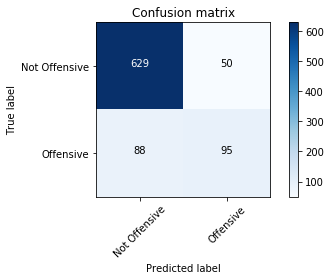

In [132]:

cn_matrix = confusion_matrix(y_test, y_pred)
print(cn_matrix)

plot_confusion_matrix(cn_matrix, ['Not Offensive', 'Offensive'])
print(f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

In [71]:
from keras.layers import LSTM, GRU, MaxPooling1D

tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = MaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = MaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = MaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
lstm = LSTM(100)(merged)
lstm = Dropout(0.2)(lstm)
lstm = Dense(1)(lstm)
output = Activation('sigmoid')(lstm)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

filepath="CNN_LSTM_W2V_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split = 0.2, callbacks = [checkpoint])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 57, 200)      4000000     input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 56, 100)      40100       embedding_14[0][0]               
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 55, 100)      60100       embedding_14[0][0]               
__________________________________________________________________________________________________
conv1d_34 

 6656/10586 [=================>............] - ETA: 1:28 - loss: 0.5295 - acc: 0.812 - ETA: 1:28 - loss: 0.4643 - acc: 0.812 - ETA: 1:33 - loss: 0.4780 - acc: 0.791 - ETA: 1:34 - loss: 0.4601 - acc: 0.796 - ETA: 1:34 - loss: 0.4517 - acc: 0.800 - ETA: 1:35 - loss: 0.4554 - acc: 0.796 - ETA: 1:36 - loss: 0.4306 - acc: 0.808 - ETA: 1:37 - loss: 0.4393 - acc: 0.808 - ETA: 1:37 - loss: 0.4403 - acc: 0.805 - ETA: 1:38 - loss: 0.4397 - acc: 0.803 - ETA: 1:38 - loss: 0.4512 - acc: 0.792 - ETA: 1:38 - loss: 0.4620 - acc: 0.786 - ETA: 1:38 - loss: 0.4549 - acc: 0.790 - ETA: 1:37 - loss: 0.4503 - acc: 0.796 - ETA: 1:37 - loss: 0.4557 - acc: 0.793 - ETA: 1:37 - loss: 0.4497 - acc: 0.794 - ETA: 1:37 - loss: 0.4520 - acc: 0.790 - ETA: 1:37 - loss: 0.4519 - acc: 0.791 - ETA: 1:37 - loss: 0.4434 - acc: 0.796 - ETA: 1:37 - loss: 0.4420 - acc: 0.798 - ETA: 1:37 - loss: 0.4527 - acc: 0.790 - ETA: 1:36 - loss: 0.4534 - acc: 0.786 - ETA: 1:36 - loss: 0.4494 - acc: 0.790 - ETA: 1:35 - loss: 0.4506 - acc: 0

10586/10586 [==============================] - ETA: 38s - loss: 0.4449 - acc: 0.79 - ETA: 37s - loss: 0.4444 - acc: 0.79 - ETA: 37s - loss: 0.4455 - acc: 0.79 - ETA: 37s - loss: 0.4450 - acc: 0.79 - ETA: 36s - loss: 0.4449 - acc: 0.79 - ETA: 36s - loss: 0.4445 - acc: 0.79 - ETA: 36s - loss: 0.4454 - acc: 0.79 - ETA: 35s - loss: 0.4451 - acc: 0.79 - ETA: 35s - loss: 0.4455 - acc: 0.79 - ETA: 35s - loss: 0.4455 - acc: 0.79 - ETA: 34s - loss: 0.4460 - acc: 0.79 - ETA: 34s - loss: 0.4460 - acc: 0.79 - ETA: 34s - loss: 0.4466 - acc: 0.79 - ETA: 33s - loss: 0.4466 - acc: 0.79 - ETA: 33s - loss: 0.4470 - acc: 0.79 - ETA: 33s - loss: 0.4468 - acc: 0.79 - ETA: 33s - loss: 0.4460 - acc: 0.79 - ETA: 32s - loss: 0.4464 - acc: 0.79 - ETA: 32s - loss: 0.4470 - acc: 0.79 - ETA: 32s - loss: 0.4472 - acc: 0.79 - ETA: 31s - loss: 0.4469 - acc: 0.79 - ETA: 31s - loss: 0.4466 - acc: 0.79 - ETA: 31s - loss: 0.4466 - acc: 0.79 - ETA: 30s - loss: 0.4469 - acc: 0.79 - ETA: 30s - loss: 0.4466 - acc: 0.79 - ETA

 6624/10586 [=================>............] - ETA: 1:34 - loss: 0.1126 - acc: 0.968 - ETA: 1:38 - loss: 0.1102 - acc: 0.968 - ETA: 1:41 - loss: 0.0961 - acc: 0.979 - ETA: 1:42 - loss: 0.0934 - acc: 0.984 - ETA: 1:42 - loss: 0.0986 - acc: 0.975 - ETA: 1:41 - loss: 0.1030 - acc: 0.974 - ETA: 1:41 - loss: 0.1020 - acc: 0.973 - ETA: 1:40 - loss: 0.1111 - acc: 0.972 - ETA: 1:40 - loss: 0.1286 - acc: 0.965 - ETA: 1:40 - loss: 0.1275 - acc: 0.965 - ETA: 1:39 - loss: 0.1401 - acc: 0.957 - ETA: 1:40 - loss: 0.1350 - acc: 0.960 - ETA: 1:39 - loss: 0.1345 - acc: 0.961 - ETA: 1:39 - loss: 0.1348 - acc: 0.962 - ETA: 1:39 - loss: 0.1294 - acc: 0.964 - ETA: 1:39 - loss: 0.1320 - acc: 0.962 - ETA: 1:38 - loss: 0.1340 - acc: 0.959 - ETA: 1:38 - loss: 0.1312 - acc: 0.960 - ETA: 1:37 - loss: 0.1277 - acc: 0.962 - ETA: 1:37 - loss: 0.1235 - acc: 0.962 - ETA: 1:37 - loss: 0.1217 - acc: 0.962 - ETA: 1:36 - loss: 0.1179 - acc: 0.964 - ETA: 1:36 - loss: 0.1268 - acc: 0.959 - ETA: 1:36 - loss: 0.1262 - acc: 0

10586/10586 [==============================] - ETA: 39s - loss: 0.1162 - acc: 0.95 - ETA: 39s - loss: 0.1167 - acc: 0.95 - ETA: 38s - loss: 0.1163 - acc: 0.95 - ETA: 38s - loss: 0.1167 - acc: 0.95 - ETA: 38s - loss: 0.1174 - acc: 0.95 - ETA: 37s - loss: 0.1189 - acc: 0.95 - ETA: 37s - loss: 0.1186 - acc: 0.95 - ETA: 37s - loss: 0.1187 - acc: 0.95 - ETA: 36s - loss: 0.1192 - acc: 0.95 - ETA: 36s - loss: 0.1195 - acc: 0.95 - ETA: 36s - loss: 0.1194 - acc: 0.95 - ETA: 35s - loss: 0.1199 - acc: 0.95 - ETA: 35s - loss: 0.1198 - acc: 0.95 - ETA: 35s - loss: 0.1197 - acc: 0.95 - ETA: 34s - loss: 0.1205 - acc: 0.95 - ETA: 34s - loss: 0.1204 - acc: 0.95 - ETA: 34s - loss: 0.1203 - acc: 0.95 - ETA: 33s - loss: 0.1204 - acc: 0.95 - ETA: 33s - loss: 0.1205 - acc: 0.95 - ETA: 33s - loss: 0.1204 - acc: 0.95 - ETA: 32s - loss: 0.1202 - acc: 0.95 - ETA: 32s - loss: 0.1202 - acc: 0.95 - ETA: 32s - loss: 0.1205 - acc: 0.95 - ETA: 31s - loss: 0.1206 - acc: 0.95 - ETA: 31s - loss: 0.1206 - acc: 0.95 - ETA

 6624/10586 [=================>............] - ETA: 1:31 - loss: 0.0572 - acc: 0.968 - ETA: 1:37 - loss: 0.0461 - acc: 0.968 - ETA: 1:41 - loss: 0.0347 - acc: 0.979 - ETA: 1:40 - loss: 0.0641 - acc: 0.968 - ETA: 1:42 - loss: 0.0578 - acc: 0.975 - ETA: 1:41 - loss: 0.0491 - acc: 0.979 - ETA: 1:42 - loss: 0.0436 - acc: 0.982 - ETA: 1:42 - loss: 0.0395 - acc: 0.984 - ETA: 1:41 - loss: 0.0444 - acc: 0.982 - ETA: 1:41 - loss: 0.0426 - acc: 0.984 - ETA: 1:42 - loss: 0.0392 - acc: 0.985 - ETA: 1:41 - loss: 0.0368 - acc: 0.987 - ETA: 1:41 - loss: 0.0400 - acc: 0.985 - ETA: 1:41 - loss: 0.0408 - acc: 0.984 - ETA: 1:41 - loss: 0.0399 - acc: 0.985 - ETA: 1:40 - loss: 0.0381 - acc: 0.986 - ETA: 1:40 - loss: 0.0362 - acc: 0.987 - ETA: 1:40 - loss: 0.0365 - acc: 0.986 - ETA: 1:39 - loss: 0.0361 - acc: 0.985 - ETA: 1:39 - loss: 0.0345 - acc: 0.985 - ETA: 1:38 - loss: 0.0330 - acc: 0.986 - ETA: 1:38 - loss: 0.0332 - acc: 0.987 - ETA: 1:38 - loss: 0.0325 - acc: 0.987 - ETA: 1:37 - loss: 0.0318 - acc: 0

10586/10586 [==============================] - ETA: 38s - loss: 0.0288 - acc: 0.99 - ETA: 38s - loss: 0.0287 - acc: 0.99 - ETA: 38s - loss: 0.0290 - acc: 0.99 - ETA: 38s - loss: 0.0295 - acc: 0.99 - ETA: 37s - loss: 0.0299 - acc: 0.99 - ETA: 37s - loss: 0.0298 - acc: 0.99 - ETA: 37s - loss: 0.0298 - acc: 0.99 - ETA: 36s - loss: 0.0297 - acc: 0.99 - ETA: 36s - loss: 0.0296 - acc: 0.99 - ETA: 36s - loss: 0.0296 - acc: 0.99 - ETA: 35s - loss: 0.0297 - acc: 0.99 - ETA: 35s - loss: 0.0296 - acc: 0.99 - ETA: 35s - loss: 0.0295 - acc: 0.99 - ETA: 34s - loss: 0.0296 - acc: 0.99 - ETA: 34s - loss: 0.0299 - acc: 0.99 - ETA: 34s - loss: 0.0299 - acc: 0.99 - ETA: 33s - loss: 0.0299 - acc: 0.99 - ETA: 33s - loss: 0.0297 - acc: 0.99 - ETA: 33s - loss: 0.0296 - acc: 0.99 - ETA: 32s - loss: 0.0295 - acc: 0.99 - ETA: 32s - loss: 0.0294 - acc: 0.99 - ETA: 32s - loss: 0.0293 - acc: 0.99 - ETA: 31s - loss: 0.0292 - acc: 0.99 - ETA: 31s - loss: 0.0292 - acc: 0.99 - ETA: 31s - loss: 0.0296 - acc: 0.99 - ETA

 6624/10586 [=================>............] - ETA: 1:28 - loss: 0.0397 - acc: 0.968 - ETA: 1:31 - loss: 0.0205 - acc: 0.984 - ETA: 1:38 - loss: 0.0153 - acc: 0.989 - ETA: 1:40 - loss: 0.0124 - acc: 0.992 - ETA: 1:39 - loss: 0.0115 - acc: 0.993 - ETA: 1:40 - loss: 0.0099 - acc: 0.994 - ETA: 1:40 - loss: 0.0101 - acc: 0.995 - ETA: 1:40 - loss: 0.0129 - acc: 0.992 - ETA: 1:40 - loss: 0.0134 - acc: 0.993 - ETA: 1:40 - loss: 0.0128 - acc: 0.993 - ETA: 1:39 - loss: 0.0179 - acc: 0.991 - ETA: 1:39 - loss: 0.0247 - acc: 0.989 - ETA: 1:40 - loss: 0.0234 - acc: 0.990 - ETA: 1:40 - loss: 0.0223 - acc: 0.991 - ETA: 1:39 - loss: 0.0209 - acc: 0.991 - ETA: 1:38 - loss: 0.0204 - acc: 0.992 - ETA: 1:38 - loss: 0.0237 - acc: 0.989 - ETA: 1:38 - loss: 0.0226 - acc: 0.989 - ETA: 1:38 - loss: 0.0223 - acc: 0.990 - ETA: 1:38 - loss: 0.0214 - acc: 0.990 - ETA: 1:38 - loss: 0.0205 - acc: 0.991 - ETA: 1:37 - loss: 0.0197 - acc: 0.991 - ETA: 1:37 - loss: 0.0190 - acc: 0.991 - ETA: 1:37 - loss: 0.0185 - acc: 0

10586/10586 [==============================] - ETA: 38s - loss: 0.0138 - acc: 0.99 - ETA: 38s - loss: 0.0138 - acc: 0.99 - ETA: 38s - loss: 0.0139 - acc: 0.99 - ETA: 38s - loss: 0.0139 - acc: 0.99 - ETA: 37s - loss: 0.0138 - acc: 0.99 - ETA: 37s - loss: 0.0138 - acc: 0.99 - ETA: 37s - loss: 0.0137 - acc: 0.99 - ETA: 36s - loss: 0.0137 - acc: 0.99 - ETA: 36s - loss: 0.0136 - acc: 0.99 - ETA: 36s - loss: 0.0139 - acc: 0.99 - ETA: 35s - loss: 0.0138 - acc: 0.99 - ETA: 35s - loss: 0.0138 - acc: 0.99 - ETA: 35s - loss: 0.0142 - acc: 0.99 - ETA: 34s - loss: 0.0142 - acc: 0.99 - ETA: 34s - loss: 0.0143 - acc: 0.99 - ETA: 34s - loss: 0.0143 - acc: 0.99 - ETA: 33s - loss: 0.0142 - acc: 0.99 - ETA: 33s - loss: 0.0142 - acc: 0.99 - ETA: 33s - loss: 0.0142 - acc: 0.99 - ETA: 32s - loss: 0.0142 - acc: 0.99 - ETA: 32s - loss: 0.0141 - acc: 0.99 - ETA: 32s - loss: 0.0141 - acc: 0.99 - ETA: 31s - loss: 0.0141 - acc: 0.99 - ETA: 31s - loss: 0.0140 - acc: 0.99 - ETA: 31s - loss: 0.0141 - acc: 0.99 - ETA

 6624/10586 [=================>............] - ETA: 1:39 - loss: 4.1121e-04 - acc: 1.000 - ETA: 1:43 - loss: 7.3609e-04 - acc: 1.000 - ETA: 1:44 - loss: 0.0021 - acc: 1.0000    - ETA: 1:45 - loss: 0.0019 - acc: 1.000 - ETA: 1:46 - loss: 0.0017 - acc: 1.000 - ETA: 1:45 - loss: 0.0016 - acc: 1.000 - ETA: 1:45 - loss: 0.0018 - acc: 1.000 - ETA: 1:45 - loss: 0.0017 - acc: 1.000 - ETA: 1:44 - loss: 0.0016 - acc: 1.000 - ETA: 1:44 - loss: 0.0017 - acc: 1.000 - ETA: 1:43 - loss: 0.0016 - acc: 1.000 - ETA: 1:43 - loss: 0.0015 - acc: 1.000 - ETA: 1:42 - loss: 0.0014 - acc: 1.000 - ETA: 1:42 - loss: 0.0017 - acc: 1.000 - ETA: 1:42 - loss: 0.0016 - acc: 1.000 - ETA: 1:42 - loss: 0.0072 - acc: 0.998 - ETA: 1:41 - loss: 0.0070 - acc: 0.998 - ETA: 1:41 - loss: 0.0067 - acc: 0.998 - ETA: 1:41 - loss: 0.0067 - acc: 0.998 - ETA: 1:41 - loss: 0.0064 - acc: 0.998 - ETA: 1:41 - loss: 0.0061 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0056 - acc: 0.998 - ETA: 1:39 - loss: 0.0

10586/10586 [==============================] - ETA: 39s - loss: 0.0116 - acc: 0.99 - ETA: 38s - loss: 0.0120 - acc: 0.99 - ETA: 38s - loss: 0.0120 - acc: 0.99 - ETA: 38s - loss: 0.0120 - acc: 0.99 - ETA: 37s - loss: 0.0119 - acc: 0.99 - ETA: 37s - loss: 0.0119 - acc: 0.99 - ETA: 37s - loss: 0.0120 - acc: 0.99 - ETA: 36s - loss: 0.0120 - acc: 0.99 - ETA: 36s - loss: 0.0119 - acc: 0.99 - ETA: 36s - loss: 0.0119 - acc: 0.99 - ETA: 35s - loss: 0.0119 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0118 - acc: 0.99 - ETA: 35s - loss: 0.0117 - acc: 0.99 - ETA: 34s - loss: 0.0119 - acc: 0.99 - ETA: 34s - loss: 0.0119 - acc: 0.99 - ETA: 34s - loss: 0.0119 - acc: 0.99 - ETA: 33s - loss: 0.0119 - acc: 0.99 - ETA: 33s - loss: 0.0123 - acc: 0.99 - ETA: 33s - loss: 0.0122 - acc: 0.99 - ETA: 32s - loss: 0.0122 - acc: 0.99 - ETA: 32s - loss: 0.0122 - acc: 0.99 - ETA: 32s - loss: 0.0121 - acc: 0.99 - ETA: 31s - loss: 0.0121 - acc: 0.99 - ETA: 31s - loss: 0.0121 - acc: 0.99 - ETA

In [133]:
loaded_CNN_model = load_model('CNN_LSTM_W2V_best_weights.02-0.7594.hdf5')
loaded_CNN_model.evaluate(x=X_test_seq, y=y_test)

862/862 [==============================] - ETA: 20 - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 6ms/step


[0.4381235528158201, 0.8062645006069175]

[[602  77]
 [ 90  93]]
Confusion matrix, without normalization
[[602  77]
 [ 90  93]]
0.7025516413444829


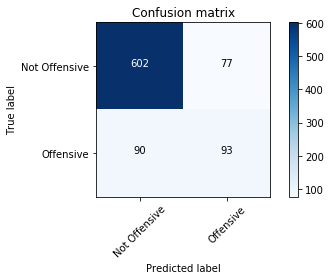

In [134]:
yhat_cnn = loaded_CNN_model.predict(X_test_seq)

y_pred = (yhat_cnn > 0.5)
cn_matrix = confusion_matrix(y_test, y_pred)
print(cn_matrix)

plot_confusion_matrix(cn_matrix, ['Not Offensive', 'Offensive'])
print(f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

In [ ]:
from keras.layers import LSTM, GRU, MaxPooling1D

tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(ggl_num_words, ggl_embedding_dimension, weights=[ggl_embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = MaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = MaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = MaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
lstm = LSTM(100)(merged)
lstm = Dropout(0.2)(lstm)
lstm = Dense(1)(lstm)
output = Activation('sigmoid')(lstm)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()